In [1]:
get_ipython().magic('matplotlib inline')
get_ipython().magic('config InlineBackend.figure_format = "retina"')

import matplotlib.pyplot as pl

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import os
import sys
import numpy as np
import pandas as pd
from scipy import stats
from configobj import ConfigObj
from astropy import constants as c
from astropy import units as u
import pprint

import limbdark

pp = pprint.PrettyPrinter(indent=2)

def map_int(x):
    return list(map(int, x))

def map_float(x):
    return list(map(float, x))

sys.path.append('..')
from transitfit import TransitFit
from transitfit.util import mad_outliers, get_init_params, u_to_q

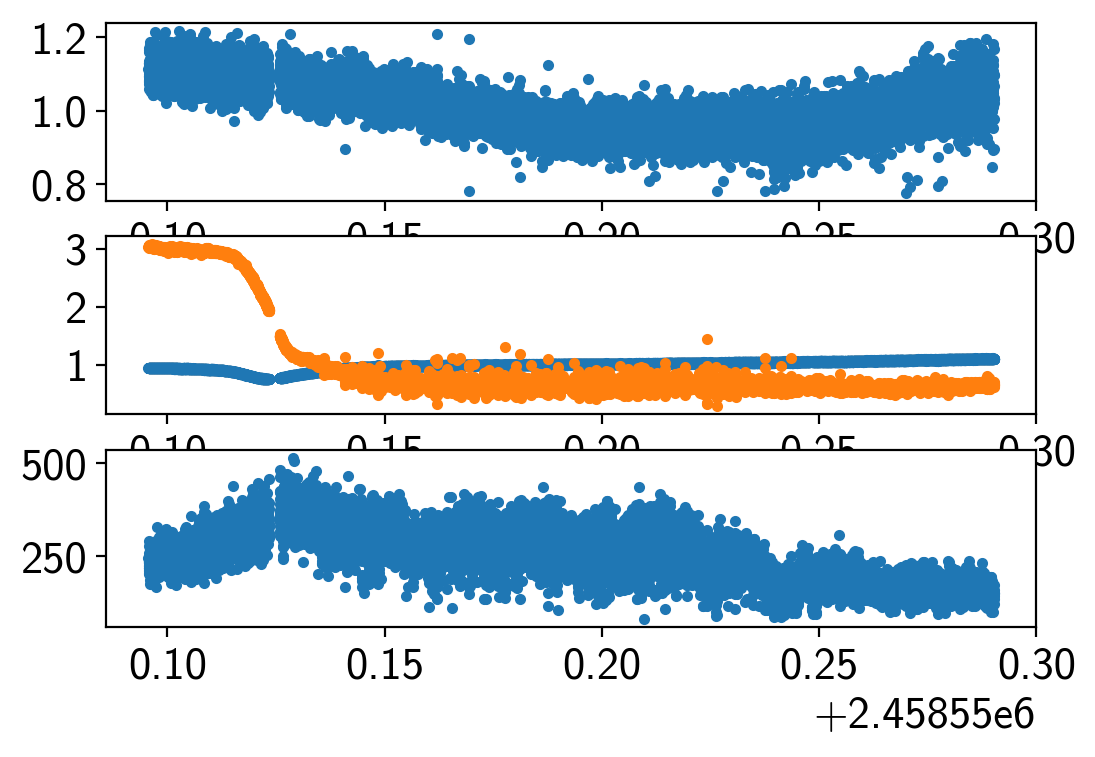

In [3]:
fp = '../data/20190307-TNT-EPIC212099230-r.txt'
df = pd.read_table(fp, delim_whitespace=True, names='t f x y peak'.split())

time, flux, cenx, ceny, peak = df.values.T

time += 2400000.5
flux /= np.median(flux)

fig, axs = pl.subplots(3, 1)
axs[0].plot(time, flux, '.')
axs[1].plot(time, cenx/cenx.mean(), '.')
axs[1].plot(time, ceny/ceny.mean(), '.')
axs[2].plot(time, peak, '.')

0


<Container object of 3 artists>

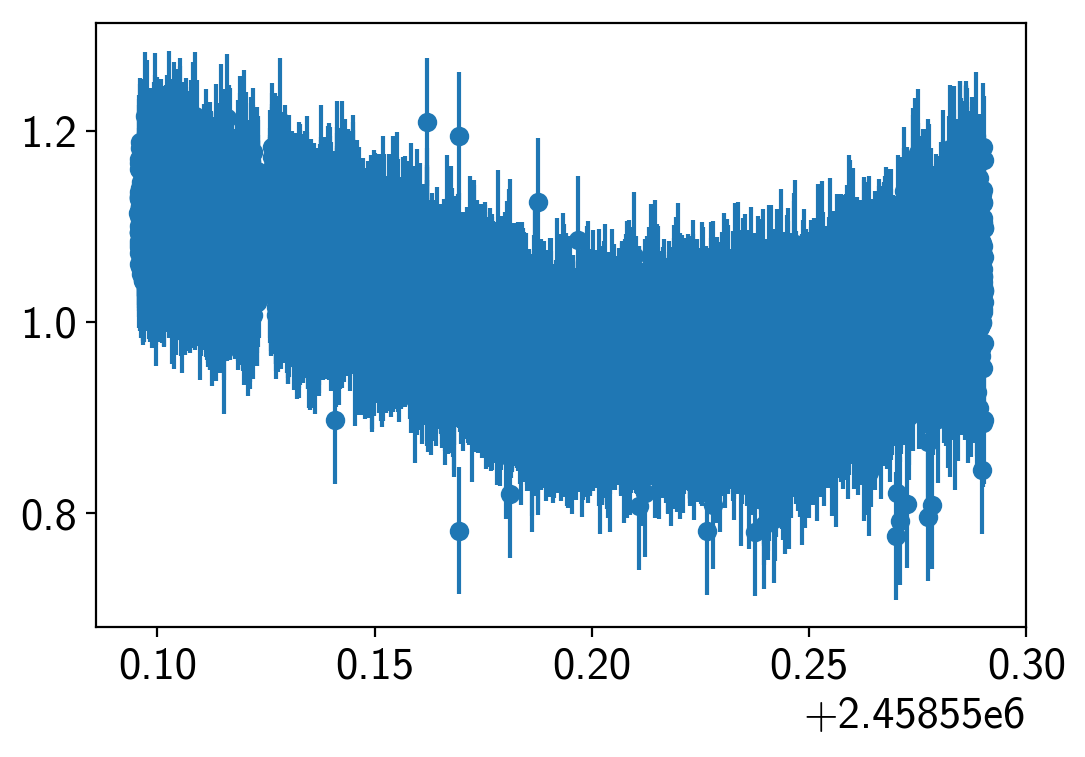

In [17]:
aux = np.c_[np.ones_like(time), time-time.min(), (time-time.min())**2, cenx/cenx.mean(), ceny/ceny.mean(), peak/peak.mean()]
# aux = np.c_[np.ones_like(time), time-time.min(), cenx/cenx.mean(), ceny/ceny.mean(), peak/peak.mean()]

idx = mad_outliers(flux)
print(idx.sum())

time, flux, aux = time[~idx], flux[~idx], aux[~idx]
unc = flux.std()

pl.errorbar(time, flux, unc, marker='o', linestyle='none')

In [18]:
# bin the data
##############

# fp = 'TOI-136_irsf_181007_j.csv'
# df = pd.read_csv(fp)

# idx = mad_outliers(df['flux'].values)
# print('omitting {} outliers'.format(idx.sum()))
# df = df[~idx]

# binsize_min = 5
# binsize = binsize_min / (60 * 24)
# print(np.diff(df['BJD_TDB']).mean()*86400)
# bins = np.arange(df['BJD_TDB'].min(), df['BJD_TDB'].max(), binsize)
# groups = df.groupby(np.digitize(df['BJD_TDB'], bins))
# df_binned = groups.mean()
# df = df_binned.copy()

# aux = df['airmass sky dx dy fwhm peak'.split()].values
# time, flux, unc = df['BJD_TDB flux err'.split()].values.T
# pl.errorbar(time, flux, unc, marker='o', linestyle='none')

In [19]:
band = 'r*'

planets = { '212099230.01': { 'per': 7.112423049927065,
                           'rprs': 0.126,
                           't0': 2457149.072778,
                           't14': 0.1445}}

star = { 'feh': [0.0, 0.5],
            'logg': [4.5, 0.5],
            'rad': [0.99, 0.06],
            'teff': [5200, 200]}

teff, logg, feh = [star.get(k) for k in 'teff logg feh'.split()]

ldp = limbdark.claret(band, teff[0], teff[1], logg[0], logg[1], feh[0], feh[1])
u1, u2 = ldp[0], ldp[2]
q1, q2 = u_to_q(u1, u2)

# logg = map_float(star['logg'])
# rad = map_float(star['rad'])
# n = 10000
# rad_s = rad[0] + np.random.randn(n) * rad[1]
# logg_s = logg[0] + np.random.randn(n) * logg[1]
# rho_s = rho(logg_s, rad_s)
# rhop = rho_s.mean(), rho_s.std()

# priors = dict(ld=ldp, rho=rhop)

pl_name = list(planets.keys())[0]
planet = planets[pl_name]
per, t0, t14, rprs = [planet.get(key) for key in 'per t0 t14 rprs'.split()]

while t0 < time.min():
    t0 += per
    
t0p = t0, 0.00000690
perp = per, 0.0007814
t14p = t14, 0.00312
priors = dict(ld=ldp, t0=t0p, per=perp, t14=t14p)
# priors = None

init_params = get_init_params(per, t0, t14, rprs, b=0.5, q1=q1, q2=q2)
init_params['priors'] = priors
init_params['ls'] = np.log(flux.std())
pp.pprint(init_params)

{ 'b': 0.5,
  'k': 0.126,
  'ls': -2.7041793174952615,
  'p': 7.112423049927065,
  'priors': { 'ld': (0.5167, 0.06837565647916223, 0.2034, 0.04475075850520413),
              'per': (7.112423049927065, 0.0007814),
              't0': (2458550.220118801, 6.9e-06),
              't14': (0.1445, 0.00312)},
  'q1': 0.51854401,
  'q2': 0.358769615331204,
  'r': 1.41,
  't0': 2458550.220118801,
  't14': 0.1445}


In [20]:
# fit = TransitFit(init_params, pl_name, time, flux, unc=unc, aux=aux)
fit = TransitFit(init_params, pl_name, time, flux, aux=aux)

In [21]:
fit.fit_map()

Initial L-M least squares fit successful
[[Variables]]
    t0:   2.4586e+06 +/- 0        (0.00%) (init= 2458550)
    p:    7.112423 (fixed)
    k:    0.126 (fixed)
    r:    1.41 (fixed)
    b:    0.67584429 +/- 0        (0.00%) (init= 0.5)
    q1:   0.518544 (fixed)
    q2:   0.3587696 (fixed)
    ls:  -2.704179 (fixed)
    c0:   0.28540875 +/- 0        (0.00%) (init= 0)
    c1:  -4.15787273 +/- 0        (0.00%) (init= 0)
    c2:   17.6035066 +/- 0        (0.00%) (init= 0)
    c3:  -0.06411447 +/- 0        (0.00%) (init= 0)
    c4:  -0.02927189 +/- 0        (0.00%) (init= 0)
    c5:   0.00688569 +/- 0        (0.00%) (init= 0)
None
Transit depth: 15876 [ppm]
Transit duration: 3.15 [h]
Log-probability: 26330.15250991974
True
[[Variables]]
    t0:   2458550 (fixed)
    p:    7.112423 (fixed)
    k:    0.126 (fixed)
    r:    1.41 (fixed)
    b:    0.70088180 (init= 0.6758443)
    q1:   0.518544 (fixed)
    q2:   0.3587696 (fixed)
    ls:  -3.29669058 (init=-2.704179)
    c0:   0.27791853

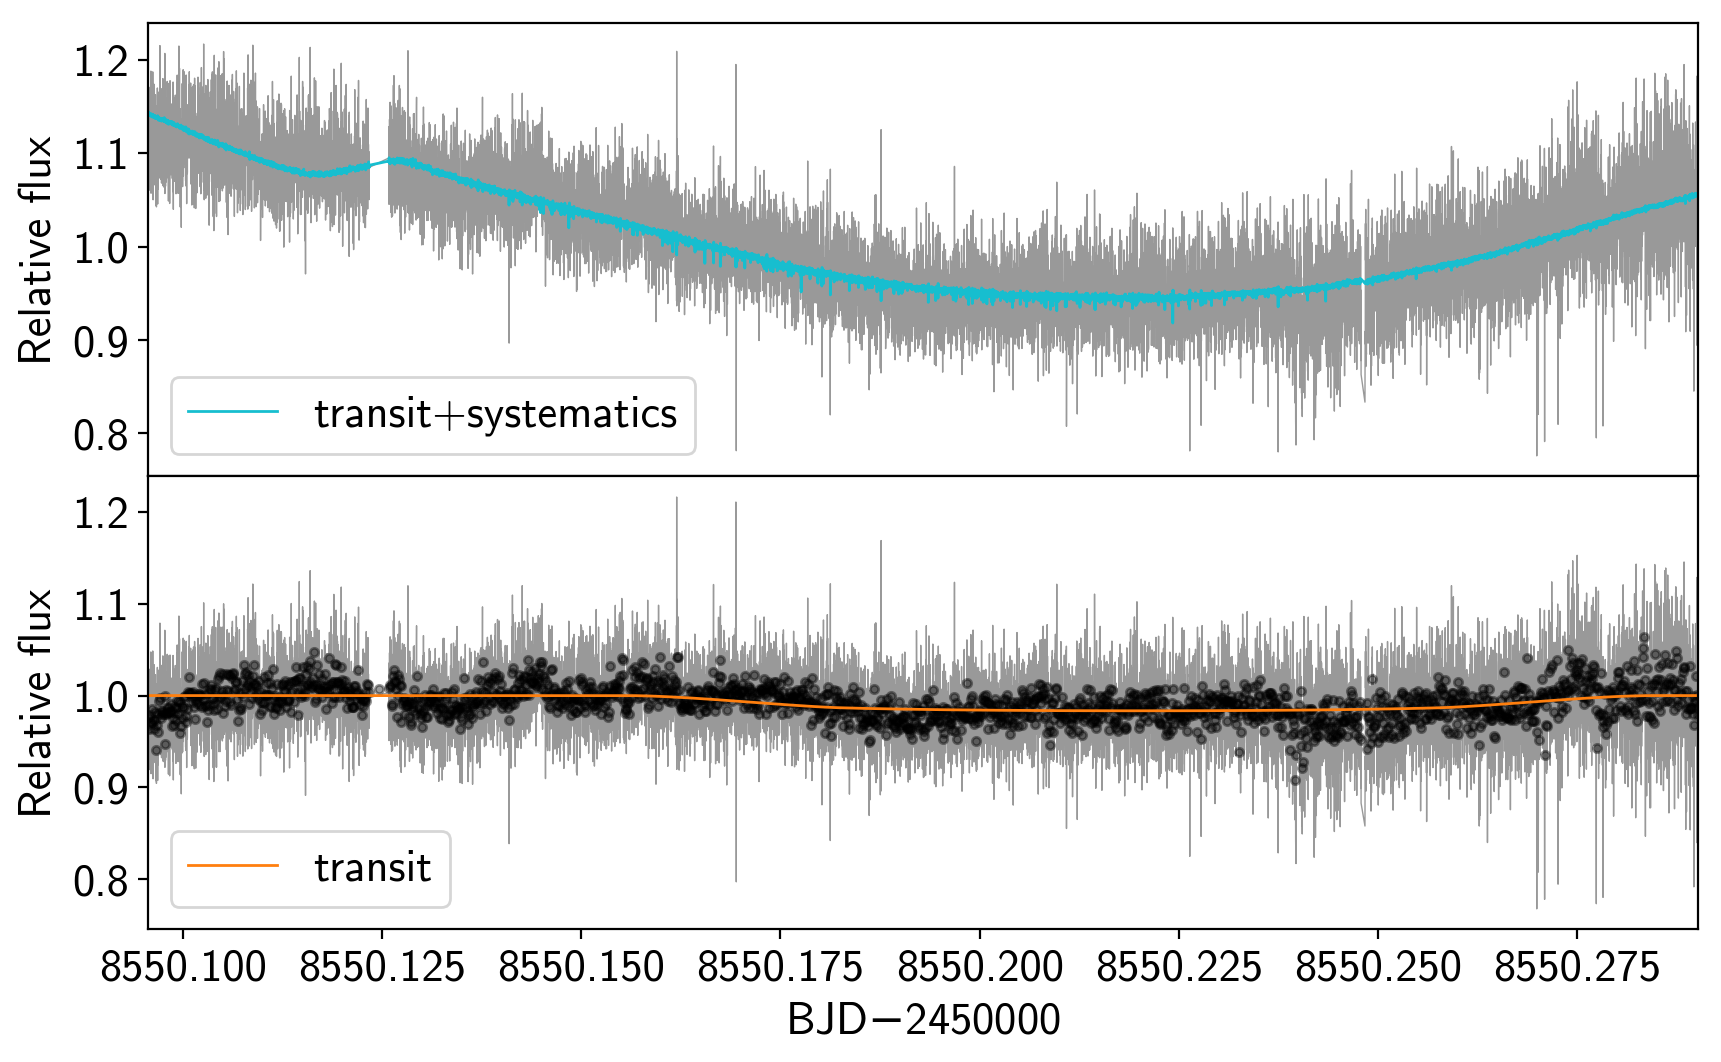

In [22]:
fit.plot_map()

In [23]:
# fit.fit_mcmc(two_stage=True)
fit.fit_mcmc(two_stage=True, steps=2000, nproc=4)

Running stage 1 MCMC (250 steps)...


../transitfit/model.py:67: RuntimeWarning: divide by zero encountered in log
  lp += np.log(stats.norm.pdf(t0, loc=t0p[0], scale=t0p[1]))
../transitfit/model.py:67: RuntimeWarning: divide by zero encountered in log
  lp += np.log(stats.norm.pdf(t0, loc=t0p[0], scale=t0p[1]))
../transitfit/model.py:67: RuntimeWarning: divide by zero encountered in log
  lp += np.log(stats.norm.pdf(t0, loc=t0p[0], scale=t0p[1]))
../transitfit/model.py:67: RuntimeWarning: divide by zero encountered in log
  lp += np.log(stats.norm.pdf(t0, loc=t0p[0], scale=t0p[1]))


Running production MCMC for 2000 steps...
[[Variables]]
    t0:   2.4586e+06 +/- 8.27e-06 (0.00%) (init= 2458550)
    p:    7.11244180 +/- 0.000819 (0.01%) (init= 7.112423)
    k:    0.25767247 +/- 0.054590 (21.19%) (init= 0.126)
    r:    1.87567393 +/- 0.331180 (17.66%) (init= 1.41)
    b:    0.59861595 +/- 0.061409 (10.26%) (init= 0.7008818)
    q1:   0.31455015 +/- 0.137955 (43.86%) (init= 0.518544)
    q2:   0.34999683 +/- 0.032556 (9.30%) (init= 0.3587696)
    ls:  -3.30966755 +/- 0.007704 (0.23%) (init=-3.296691)
    c0:   0.16093364 +/- 0.059858 (37.19%) (init= 0.2779185)
    c1:  -1.79657540 +/- 1.237845 (68.90%) (init=-4.183225)
    c2:   7.95309195 +/- 5.061447 (63.64%) (init= 17.69862)
    c3:  -0.04562915 +/- 0.011848 (25.97%) (init=-0.05716962)
    c4:   0.00053476 +/- 0.015796 (2954.00%) (init=-0.02915337)
    c5:   0.00628546 +/- 0.003017 (48.00%) (init= 0.008058612)
None
FIT_MCMC elapsed time: 623 sec


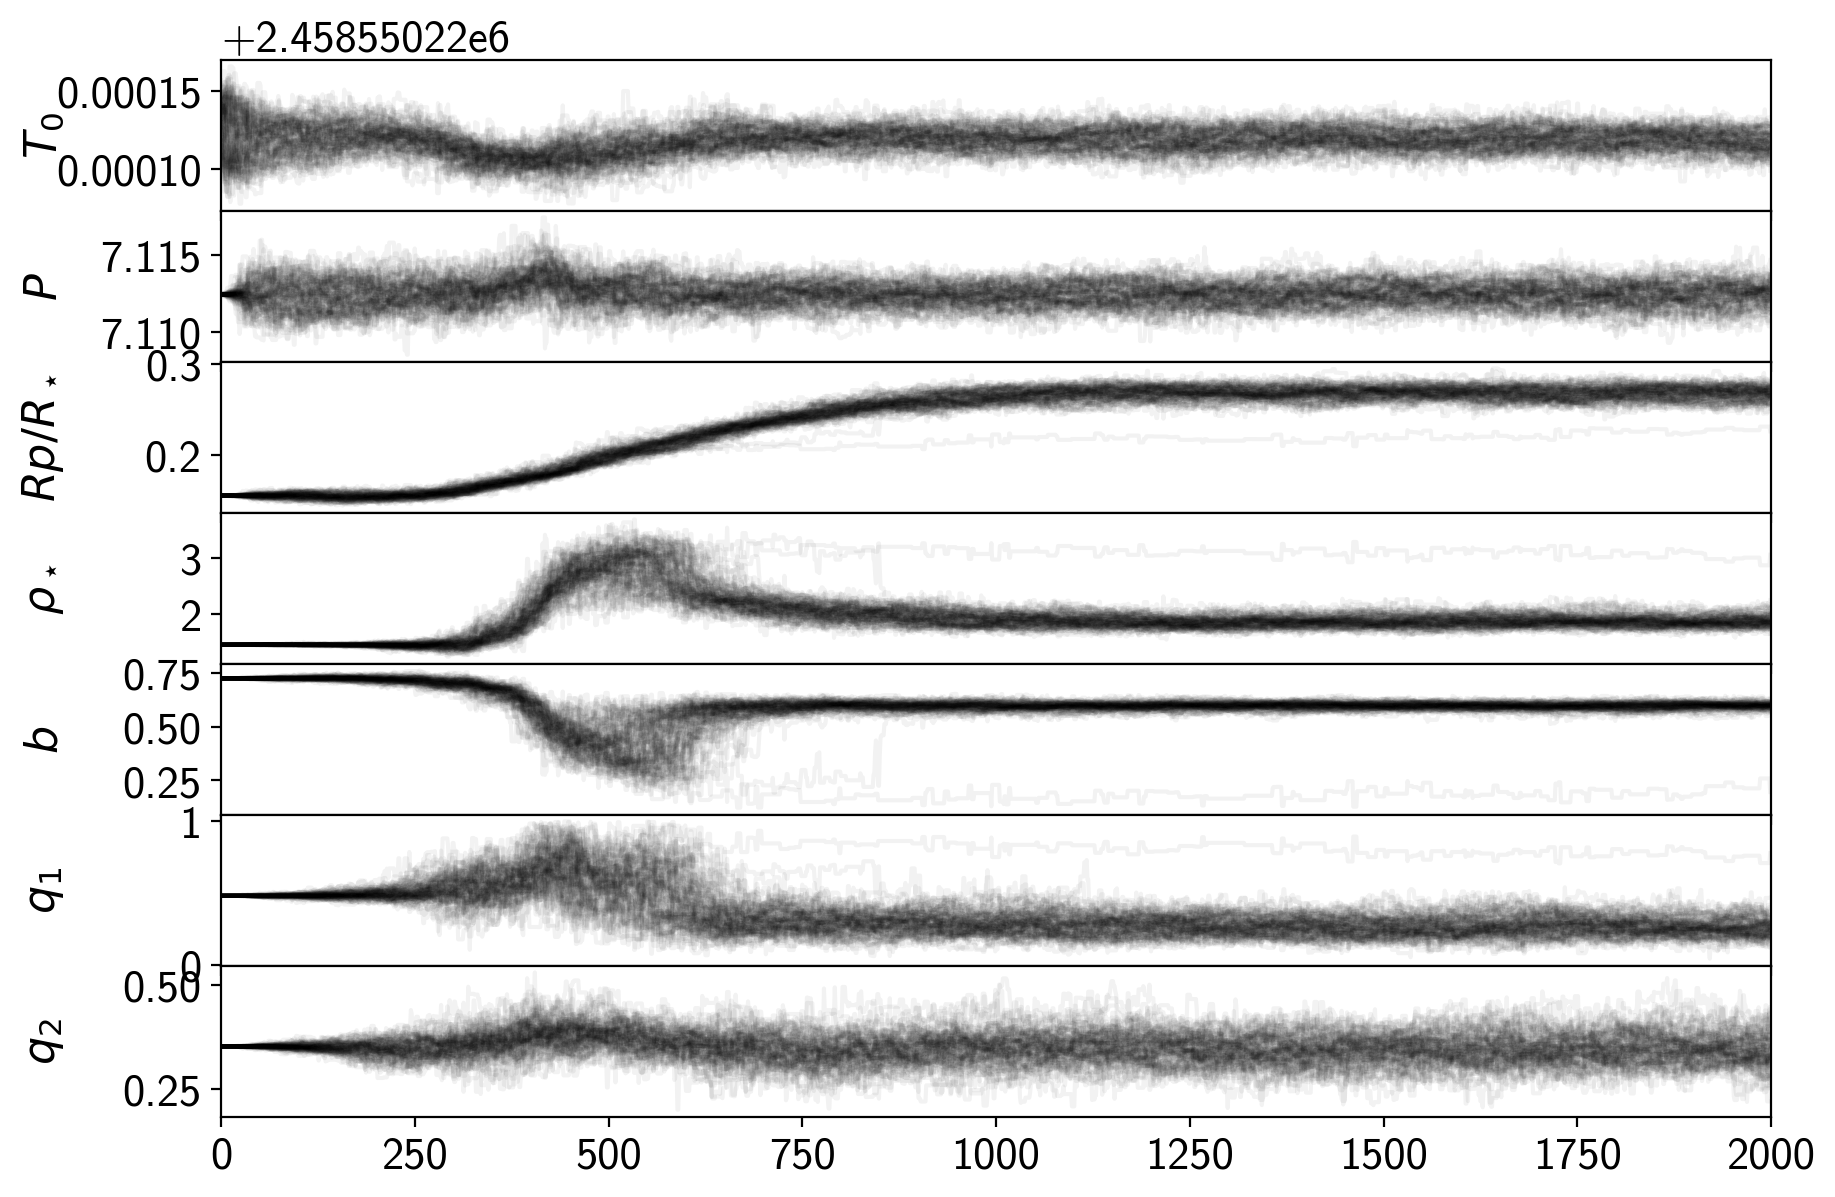

In [24]:
fit.plot_trace()

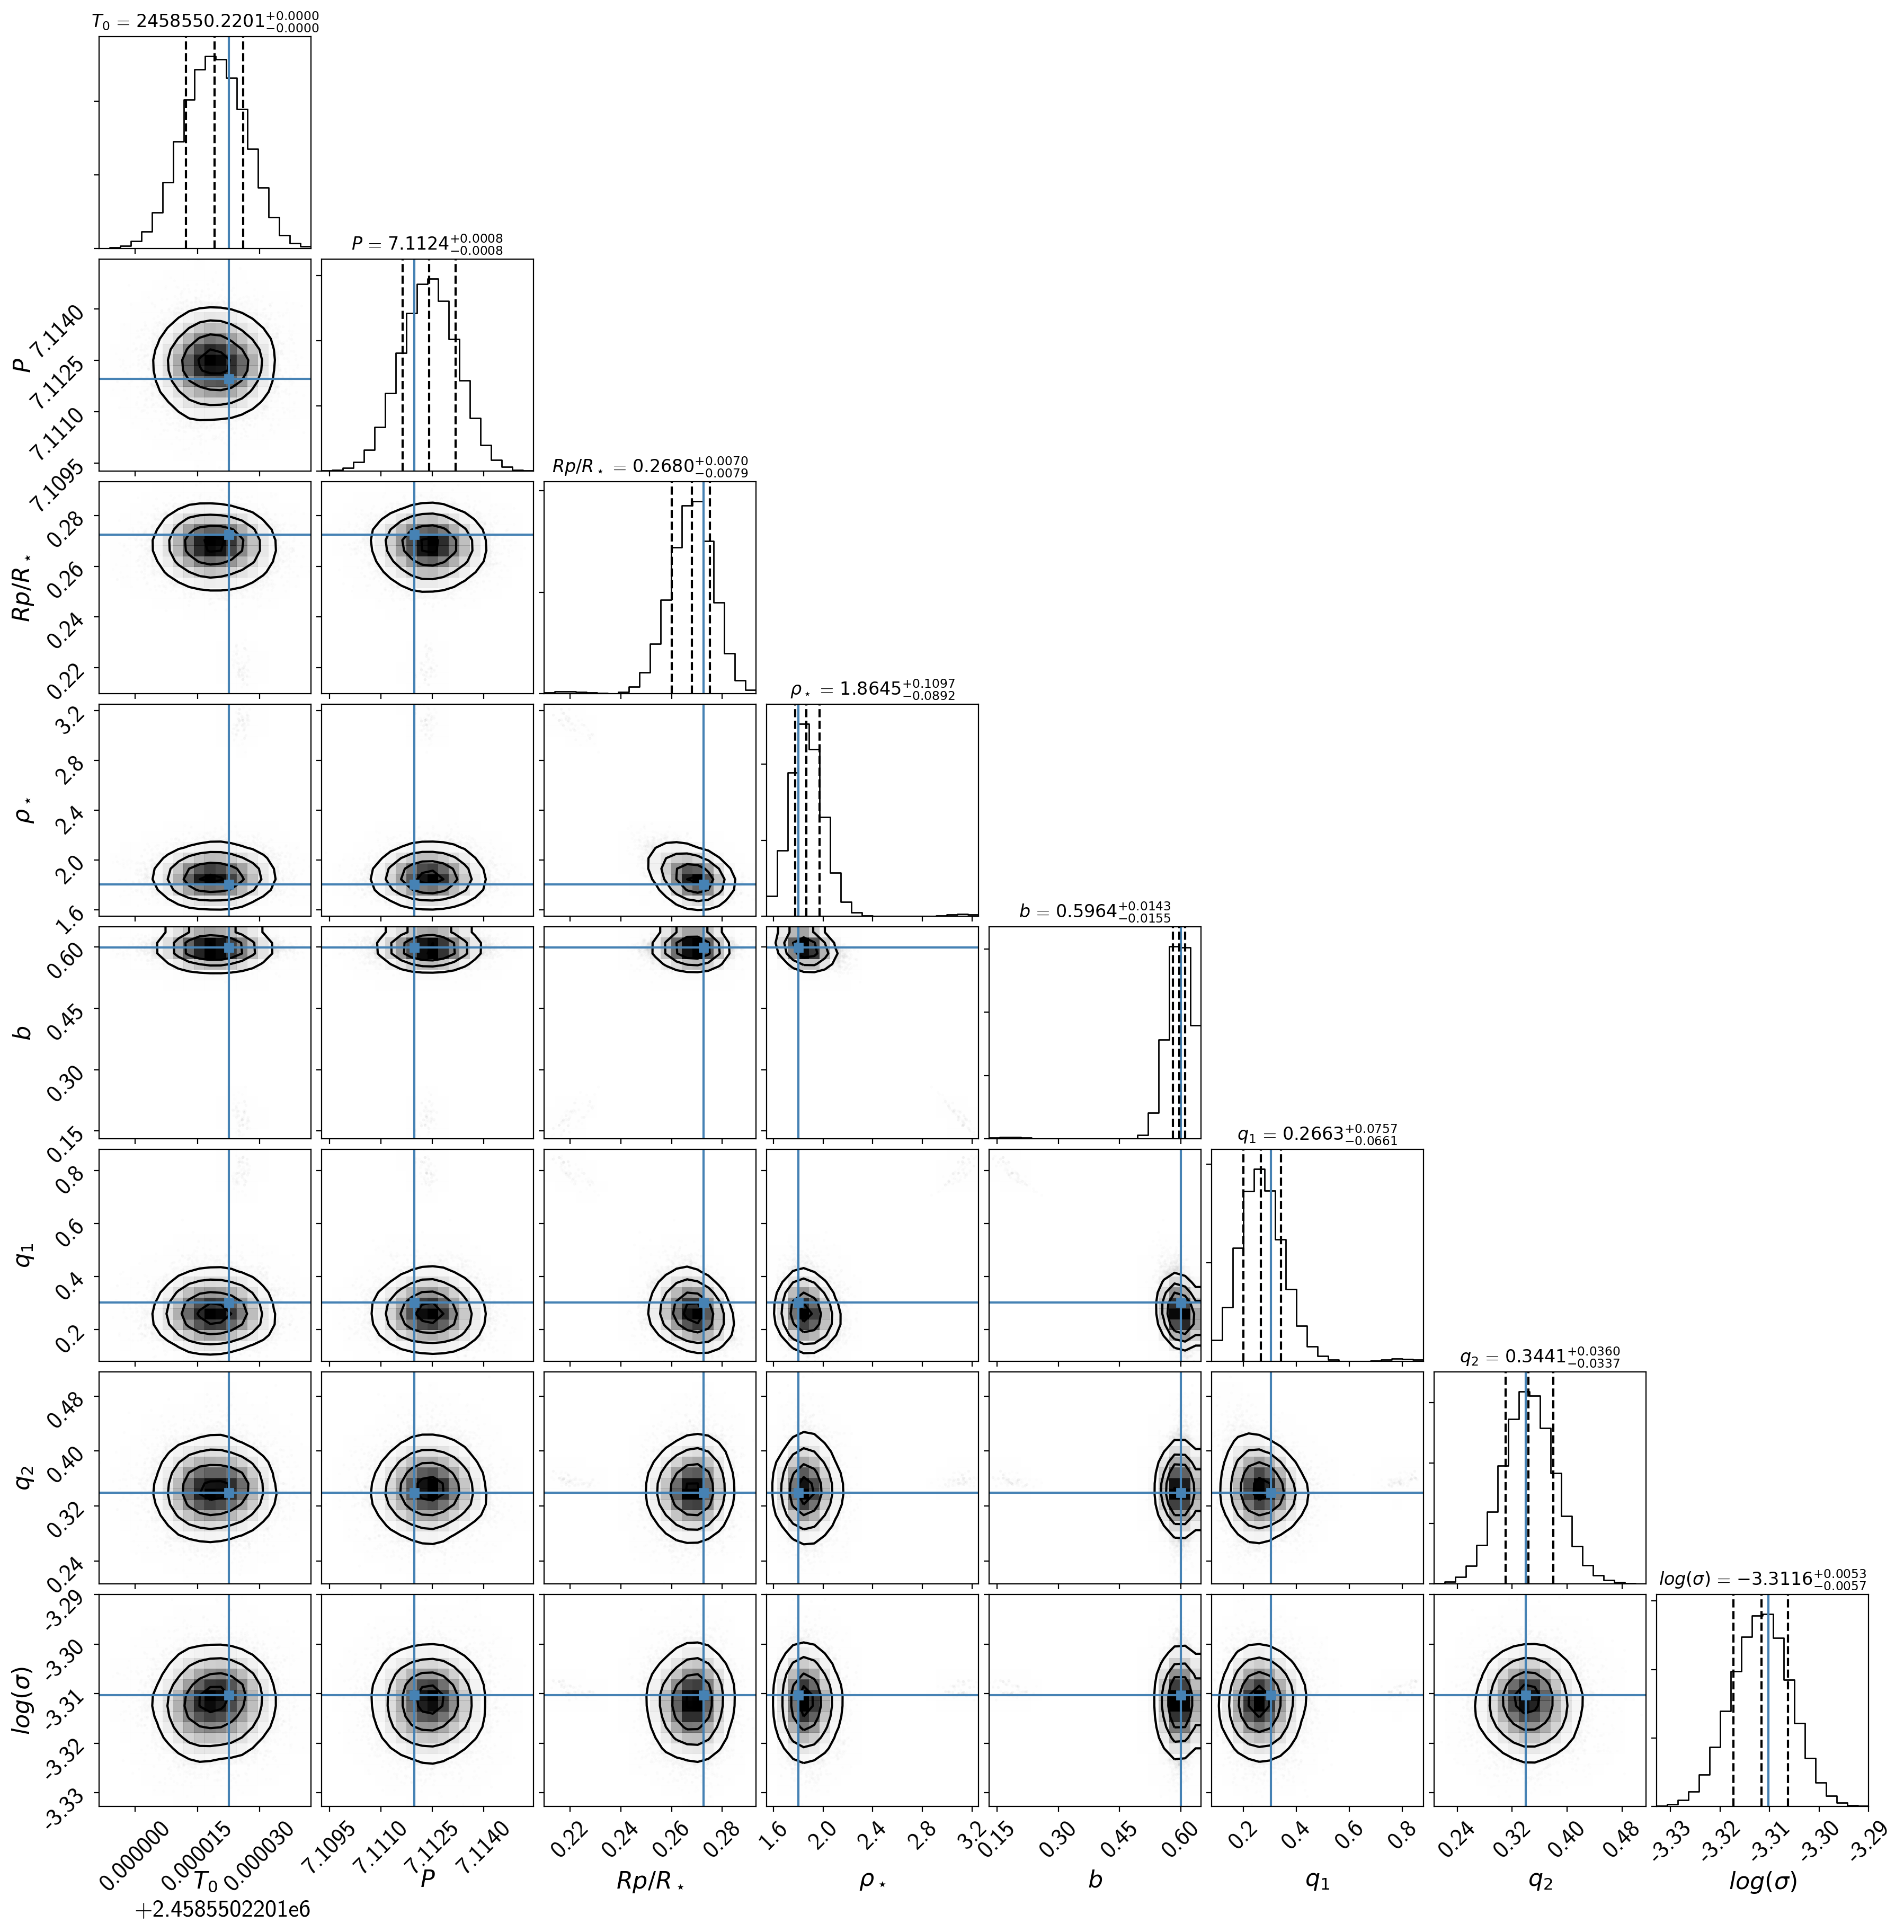

In [25]:
fit.burn_thin(burn=1000, thin=10)
fit.plot_corner()

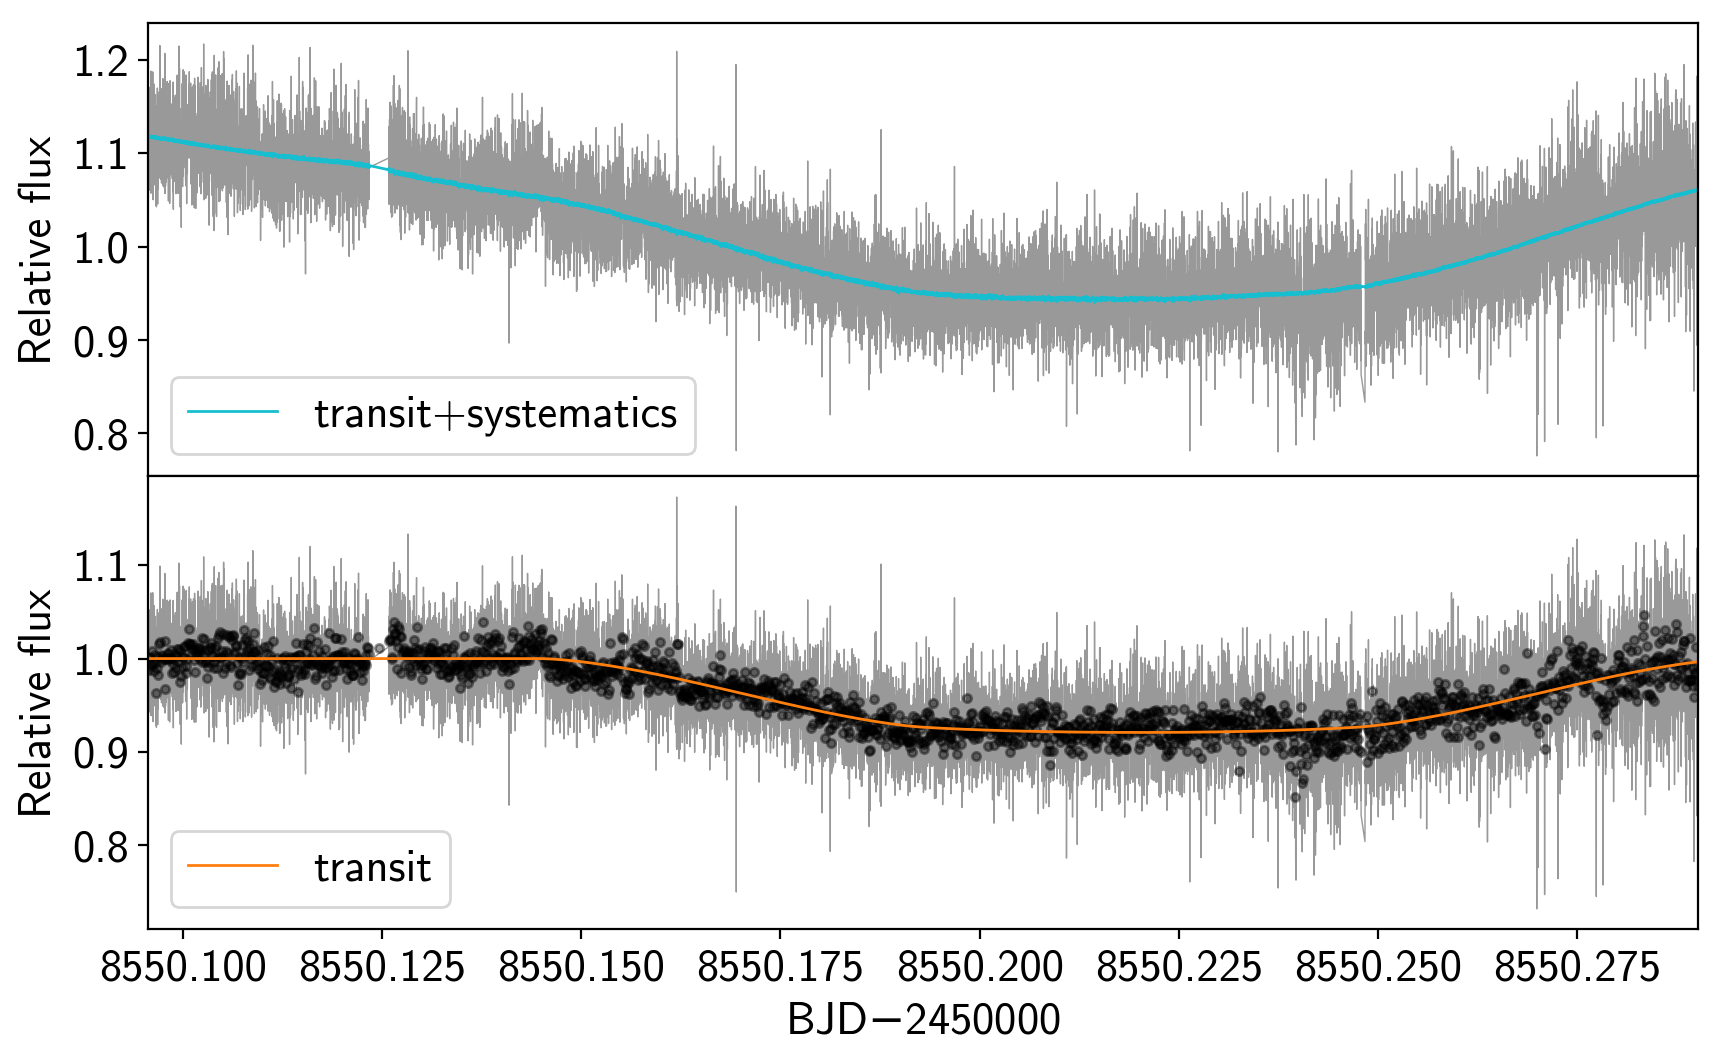

In [26]:
fit.plot_map()

[0.85, 1.05]

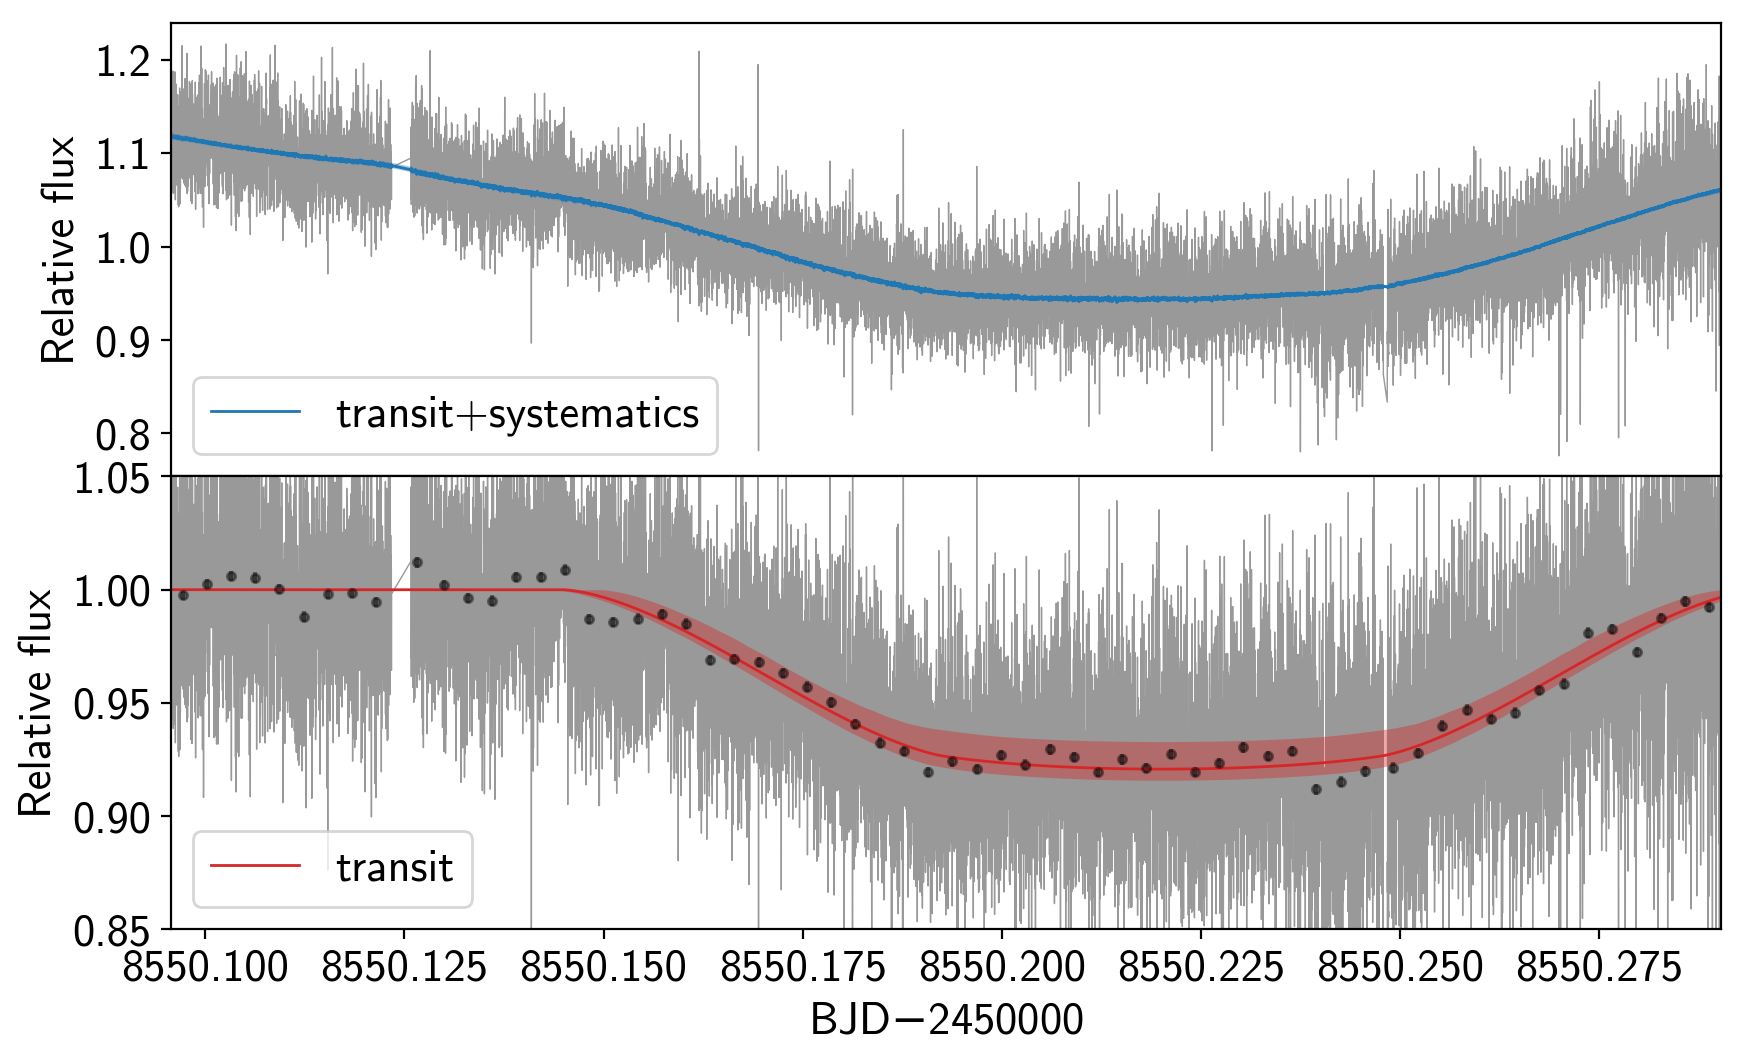

In [37]:
fig, axs = pl.subplots(2, 1, figsize=(10,6), sharex=True, sharey=False)
fit.plot_mcmc(binsize=256, c1='C0', c2='C3', axs=axs)
pl.setp(axs[1], ylim=(0.85,1.05))

In [30]:
fit.get_df(*star['rad']).describe()

,t0,p,k,r,b,q1,q2,ls,c0,c1,...,c4,c5,rstar,pl_rad,a,inc,t14,t23,shape,max_k
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.458550e+06,7.112407,0.267340,1.883809,0.591882,0.274765,0.345062,-3.311737,0.145214,-1.605132,...,0.002757,0.004977,0.989775,28.862215,17.131119,88.016258,0.148240,0.056489,0.381534,0.448403
std,6.940689e-06,0.000769,0.008668,0.157563,0.043764,0.086727,0.036156,0.005548,0.013920,0.154873,...,0.001884,0.001855,0.059791,1.978369,0.433811,0.165403,0.003253,0.003887,0.032584,0.031380
min,2.458550e+06,7.109268,0.209723,1.546396,0.130490,0.079604,0.206382,-3.332769,0.091972,-2.257208,...,-0.004060,-0.001342,0.757926,20.975364,16.050085,87.690292,0.132512,0.045454,0.291857,0.213687
25%,2.458550e+06,7.111886,0.262701,1.801727,0.586149,0.220265,0.321309,-3.315492,0.135692,-1.707340,...,0.001505,0.003681,0.950147,27.575229,16.890085,87.951937,0.146453,0.054486,0.365132,0.435353
50%,2.458550e+06,7.112410,0.268016,1.864527,0.596356,0.266334,0.344077,-3.311608,0.145269,-1.597400,...,0.002773,0.004958,0.990296,28.889217,17.083353,88.000563,0.148669,0.056217,0.379081,0.450241
75%,2.458550e+06,7.112928,0.272879,1.934666,0.606053,0.314772,0.368124,-3.307908,0.154816,-1.499415,...,0.004037,0.006238,1.029590,30.162935,17.295333,88.052492,0.150510,0.058023,0.393385,0.465060
max,2.458550e+06,7.115455,0.293273,3.249743,0.649015,0.879039,0.514989,-3.290034,0.194453,-1.071764,...,0.010367,0.011484,1.242523,36.440773,20.559088,89.636336,0.157705,0.085851,0.647871,0.548159


In [26]:
k_obs = 0.128416
maxk_3sig = 0.134141 + 3 * 0.007480

In [27]:
gamma = maxk_3sig**2 / k_obs**2
np.log10(gamma - 1) / 0.4

-0.7817205801813313

In [4]:
2.458498e+06 + 0.2995

2458498.2995